### Table of Contents

* [K-Means](#k_means)
    * [Minibatch](#minibatch_k_means)
    * [Finding the optimal number of clusters](#optimal_num_clusters)
* [Hierarchical Clustering](#hierarchical_clustering)
  

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible 
np.random.seed(42) 

In [2]:
import warnings
warnings.filterwarnings('ignore')

### utility functions

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    # take some margines so we can visualize all points
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    
    # define a gird over the domain
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    # predict clusters of the grid 
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # print the clustering boundaries and fill the regions with deifferent colors
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    # plot the data 
    plot_data(X)
    
    # plot the centroids of the clusters
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    # axis labels
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

## Gaussian Blobs data 

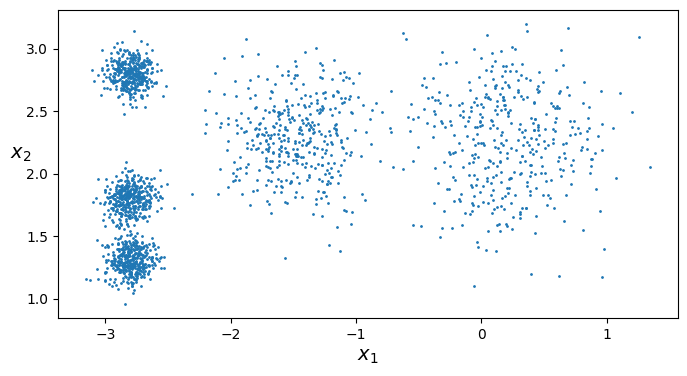

In [4]:
from sklearn.datasets import make_blobs
# Generate isotropic Gaussian blobs for clustering.
 
# centers 
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
# standard deviations 
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

# generate
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)
# Plot
plt.figure(figsize=(8, 4))
plot_clusters(X)

## K-Means <a class="anchor" id="k_means"></a>

In [5]:
from sklearn.cluster import KMeans

# number of clusters 
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

# bath refer to the same object
print(f'The assigned labels : {kmeans.labels_} which is the same as y_pred')
print(f'First three points labels {y_pred[:3]}')

print(f'The {len(kmeans.cluster_centers_)} centroids')
print('\n'.join([f'group {idx} centroid: {c}' for idx, c in enumerate(kmeans.cluster_centers_)]))
print(f'objective (cost) : {kmeans.inertia_}')

The assigned labels : [4 0 1 ... 2 1 0] which is the same as y_pred
First three points labels [4 0 1]
The 5 centroids
group 0 centroid: [-2.80389616  1.80117999]
group 1 centroid: [0.20876306 2.25551336]
group 2 centroid: [-2.79290307  2.79641063]
group 3 centroid: [-1.46679593  2.28585348]
group 4 centroid: [-2.80037642  1.30082566]
objective (cost) : 211.59853725816836


In [6]:
## assign new samples to clusters
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

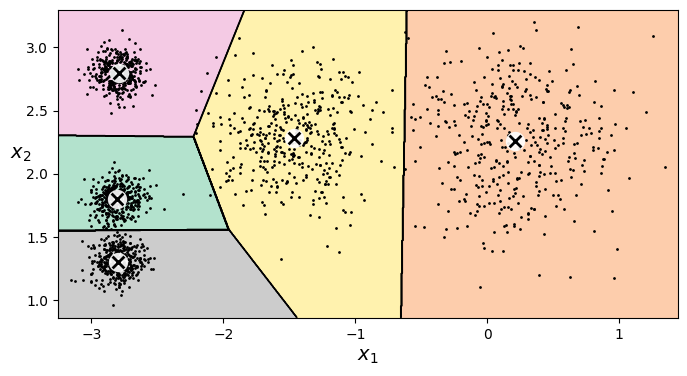

In [7]:
# plot the decision boundharies
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)


### Analyze the steps 

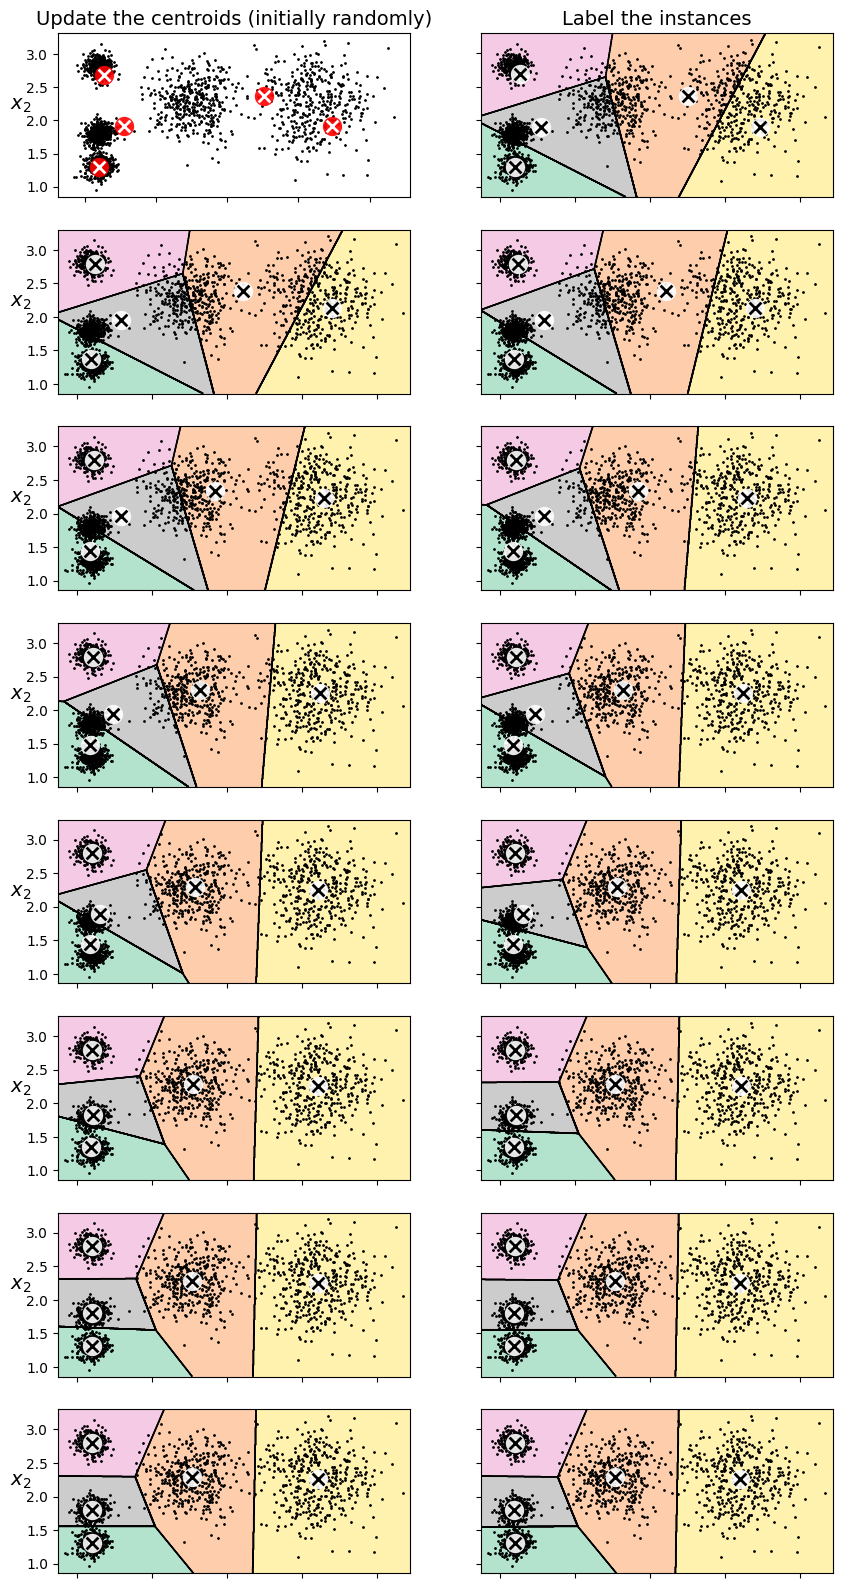

In [8]:
# random_state is set to 0 so the same initial points will be used

def get_kmeans_stages(stages: int = 3, init_centroids = None):
    
    if init_centroids is None:
        init_centroids = "random"
    for k in range(stages):
        kmeans_iter = KMeans(n_clusters=5, init=init_centroids, n_init=1,
                             algorithm="full", max_iter=k + 1, random_state=0)
        kmeans_iter.fit(X)

        yield kmeans_iter

first_stage = None
def plot_stages(X, stages: int = 3, init_centroids = None):
    
    plt.figure(figsize=(10, 20))

    # PLOT THE DATA WITH INITIAL CENTROIDS 
    plt.subplot(stages, 2, 1)
    plot_data(X)
    # get iterator over satges
    kmeans_stages = get_kmeans_stages(stages, init_centroids=init_centroids)
    first_stage = next(kmeans_stages)
    
    # CALCULATE CENTROIDS 
    plot_centroids(first_stage.cluster_centers_, circle_color='r', cross_color='w')
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.tick_params(labelbottom=False)
    plt.title("Update the centroids (initially randomly)", fontsize=14)
    
    # PLOT THE FIRST LABELS ASSIGNMENT
    plt.subplot(stages, 2, 2)
    plot_decision_boundaries(first_stage, X, show_xlabels=False, show_ylabels=False)
    plt.title("Label the instances", fontsize=14)
    
    prev_stage = first_stage
    for idx, next_stage in enumerate(kmeans_stages):
        
         # PLOT THE NEW LABELS ASSIGNMENT BASED ON PREVIOUS STAGE CENTROIDS 
        plt.subplot(stages, 2, 2 * (idx + 1) + 1)
        plot_decision_boundaries(prev_stage, X, show_centroids=False, show_xlabels=False)
        plot_centroids(next_stage.cluster_centers_)
        
        # CALCULATE NEW CENTROIDS
        plt.subplot(stages, 2, 2 * (idx + 1) + 2)
        plot_decision_boundaries(next_stage, X, show_xlabels=False, show_ylabels=False)
        
        # update previous stage
        prev_stage = next_stage
        
first_stage = plot_stages(X, 8)

### Minibatch K-Means <a class="anchor" id="minibatch_k_means"></a>

In [9]:
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

# The inertia is defined as the sum of square distances of samples to their nearest neighbor.
minibatch_kmeans.inertia_


211.652398504332

In [10]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42
)


### using memory map 

In [12]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

### Custom minibatch implementation

In [13]:
# train the model by feeding it one batch at a time. 
# implements multiple initializations and keep the model with the lowest inertia


np.random.seed(42)


def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

# number of clusters
k = 5
# number of initializations 
n_init = 10
# number of iterations per init
n_iterations = 100
# batch size 
batch_size = 100
# use more data in first iteration
init_size = 500  

# evaluate on last evaluate_on_last_n_iters batches
# note that first batches don't tell us much
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    # initialize the model
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    # get the first batch and fit
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)
    # create a new attribute named sum_inertia_ and initialize it to zero
    minibatch_kmeans.sum_inertia_ = 0
    
    for iteration in range(n_iterations):
        # get the next batch and fit
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        # will enter in the last evaluate_on_last_n_iters iterations
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans
        
# Opposite of the value of X on the K-means objective.
best_kmeans.score(X)


-211.62571878891143

## Finding the Optimal Number of Clusters <a class="anchor" id="optimal_num_clusters"></a>

In [14]:
# fit a model per number of clusters setting
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]


### Elbow

(1.0, 8.5, 0.0, 1300.0)

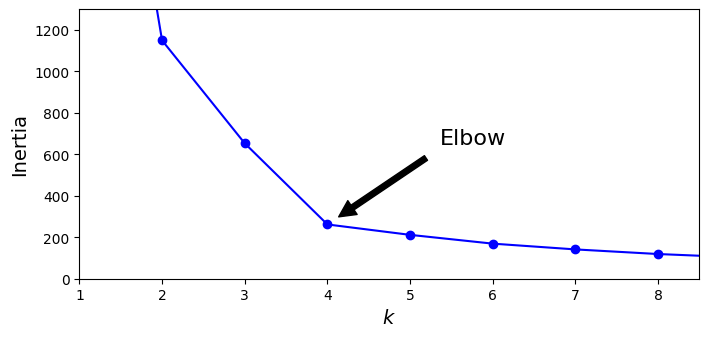

In [15]:

inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

### silhouette

(1.8, 8.5, 0.55, 0.7)

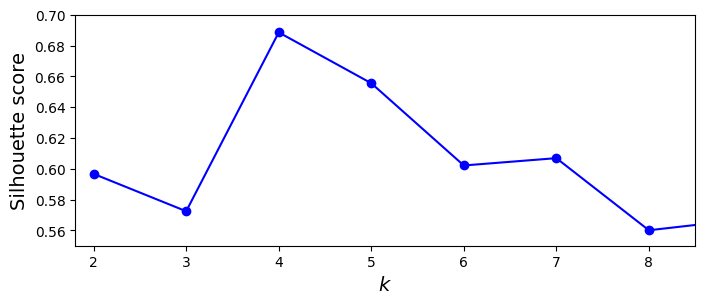

In [16]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

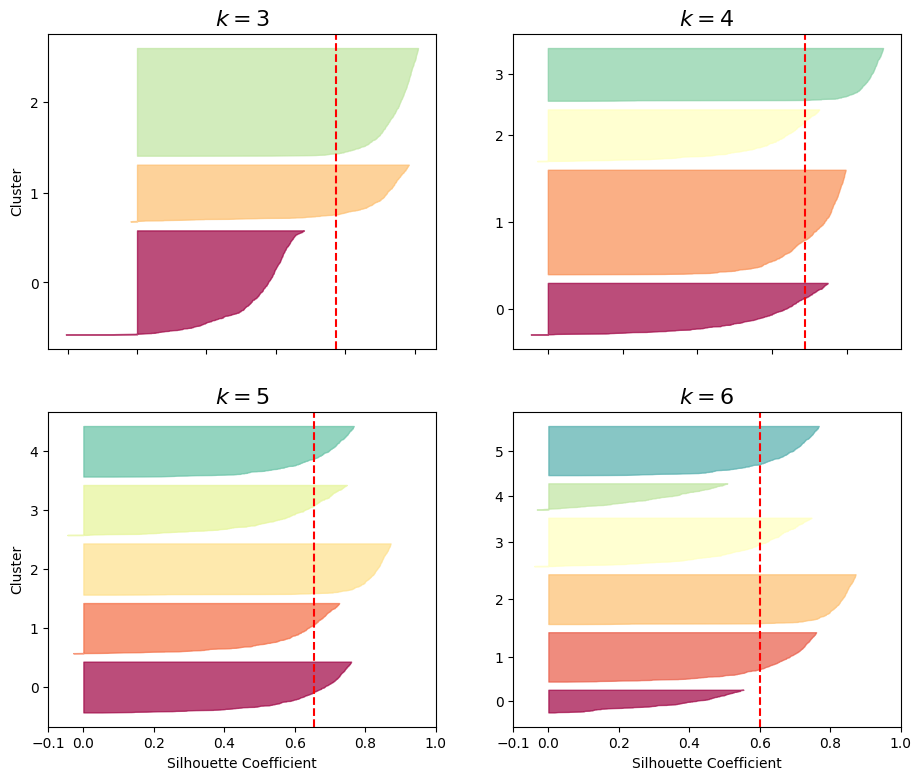

In [17]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = matplotlib.cm.Spectral(i / k)
        # Fill the area between two vertical curves.
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


## Hierarchical Clustering <a class="anchor" id="hierarchical_clustering"></a>

In [65]:
import pandas as pd

In [66]:
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### Using Scipy

In [67]:
from scipy.spatial.distance import pdist, squareform

# squareform - condensed distance matrix is passed, a redundant one is returned
# pdist - Pairwise distances between observations in n-dimensional space.
row_dist = pd.DataFrame(squareform(
    pdist(df, metric='euclidean')),
    columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [69]:
row_clusters

array([[0.        , 4.        , 3.83539555, 2.        ],
       [1.        , 2.        , 4.34707339, 2.        ],
       [3.        , 5.        , 5.89988504, 3.        ],
       [6.        , 7.        , 8.31659367, 5.        ]])

In [68]:
# Next, we will apply the complete linkage agglomeration to our clusters using the
# linkage function from SciPy's cluster.hierarchy submodule, which returns a
# so-called linkage matrix.
from scipy.cluster.hierarchy import linkage

# row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
row_clusters = linkage(df.values, metric='euclidean', method='complete')

# each row represents one merge 
# The first and second columns denote the most
# dissimilar members in each cluster, and the third column reports the distance between
# those members. The last column returns the count of the members in each cluster
df = pd.DataFrame(
    row_clusters,
    columns=['row label 1',
              'row label 2',
              'distance',
              'no. of items in clust.'],
    index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])]
)
df['row label 1'] = df['row label 1'].astype(int)
df['row label 2'] = df['row label 2'].astype(int)
df['no. of items in clust.'] = df['no. of items in clust.'].astype(int)
df

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0,4,3.835396,2
cluster 2,1,2,4.347073,2
cluster 3,3,5,5.899885,3
cluster 4,6,7,8.316594,5


Text(162.625, 0.5, 'Euclidean distance')

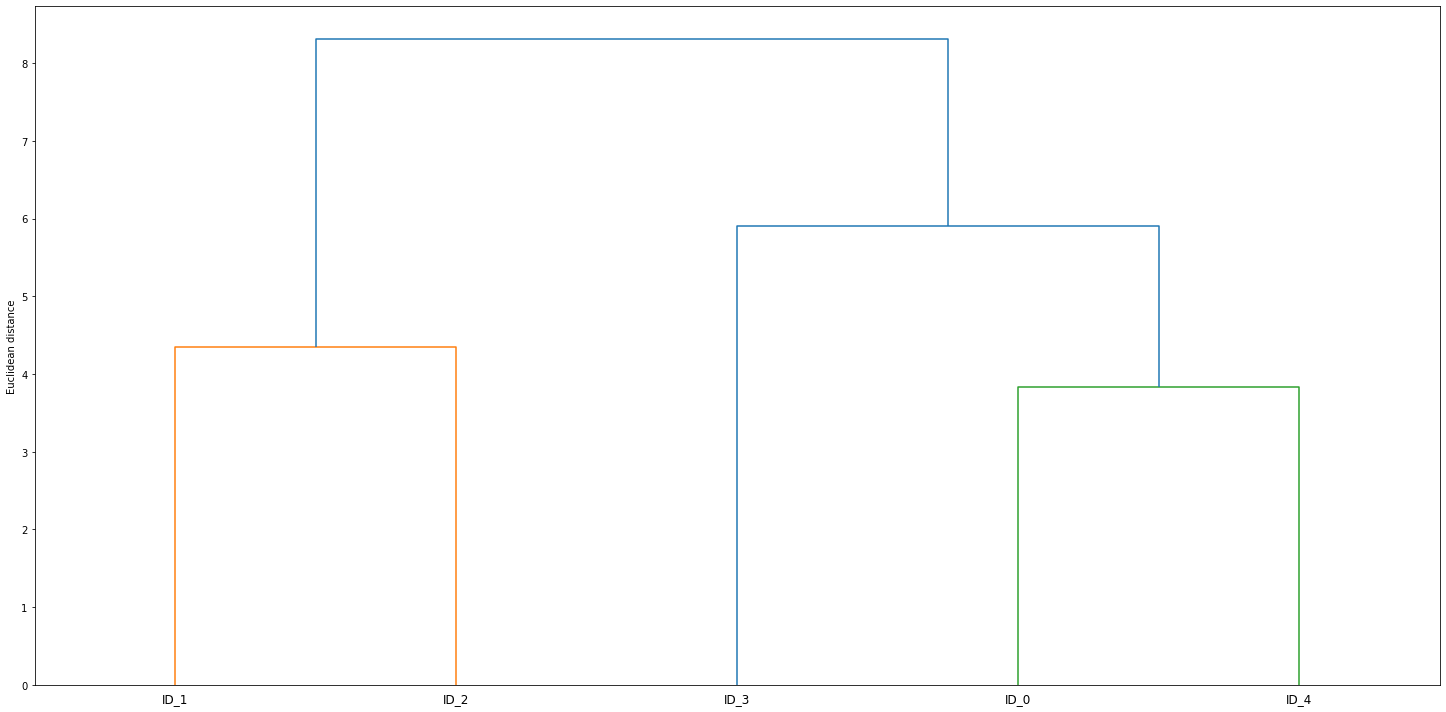

In [70]:
# Now that we have computed the linkage matrix, we can visualize the results in the
# form of a dendrogram:
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters,
    labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')

### Using Scikit 

In [71]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)
# stopped when reached 3 clusters

Cluster labels: [1 0 0 2 1]


In [72]:
ac = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)
# proceeded to merge ID_3 with ID_0 and ID_4

Cluster labels: [0 1 1 0 0]


Num clusters: 3


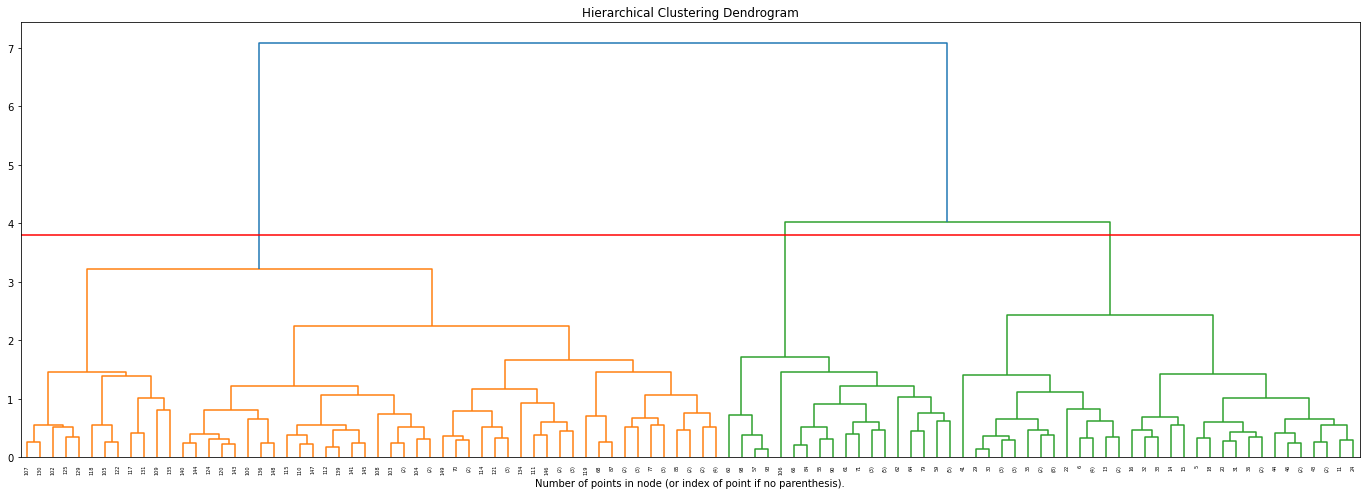

In [73]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

thresh = 3.8
# As we see there are exactly 3 clusters when limmiting the distance to 3.8
model = AgglomerativeClustering(distance_threshold=thresh, linkage='complete', n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(24, 8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top 7 levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=thresh, color='r', linestyle='-')

print(f'Num clusters: {model.n_clusters_}')